In [23]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from nn.losses import CELoss
from nn.layers import *
from nn.activations import *
from nn.utils import *
from nn.optimizers import Adam, AdaMax
from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST
from copy import deepcopy
import seaborn as sns
import pandas as pd

In [3]:
train_transforms = ToTensor()
test_transforms = ToTensor()

In [4]:
train_dataset = MNIST("mnist/train", train=True, download=True, transform=train_transforms)
test_dataset = MNIST("mnist/test", train=False, download=True, transform=test_transforms)

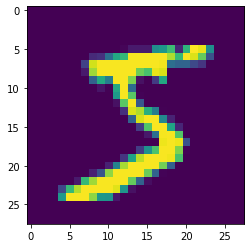

In [5]:
plt.imshow(train_dataset[0][0].cpu().numpy().transpose(1, 2, 0))

In [6]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
net = Sequential([
    Conv2D(in_channels=1, out_channels=3, stride=1, kernel_size=3),
    ReLU(),
    MaxPool2D(stride=2, kernel_size=3),
    Conv2D(in_channels=3, out_channels=5, stride=1, kernel_size=3),
    ReLU(),
    MaxPool2D(stride=2, kernel_size=3),
    Flatten(),
    Linear(80, len(test_dataset.classes)),
    SoftMax()
])

In [8]:
opt_results = {}
for Opt, opt_name in zip((Adam, AdaMax), ('Adam', 'AdaMax')):
    model = deepcopy(net)
    optimizer = Opt(model.params(), 7e-4)
    loss = CELoss()

    history = train(net=model, optimizer=optimizer, loss=loss, loader=train_loader, epochs=3)
    all_targets, all_preds = predict(model, test_loader)
    opt_results[opt_name] = {
        'losses': history,
        'targets': all_targets,
        'preds': all_preds
    }

0.27787035132120896: 100%|██████████| 3/3 [1:44:12<00:00, 2084.25s/it]   


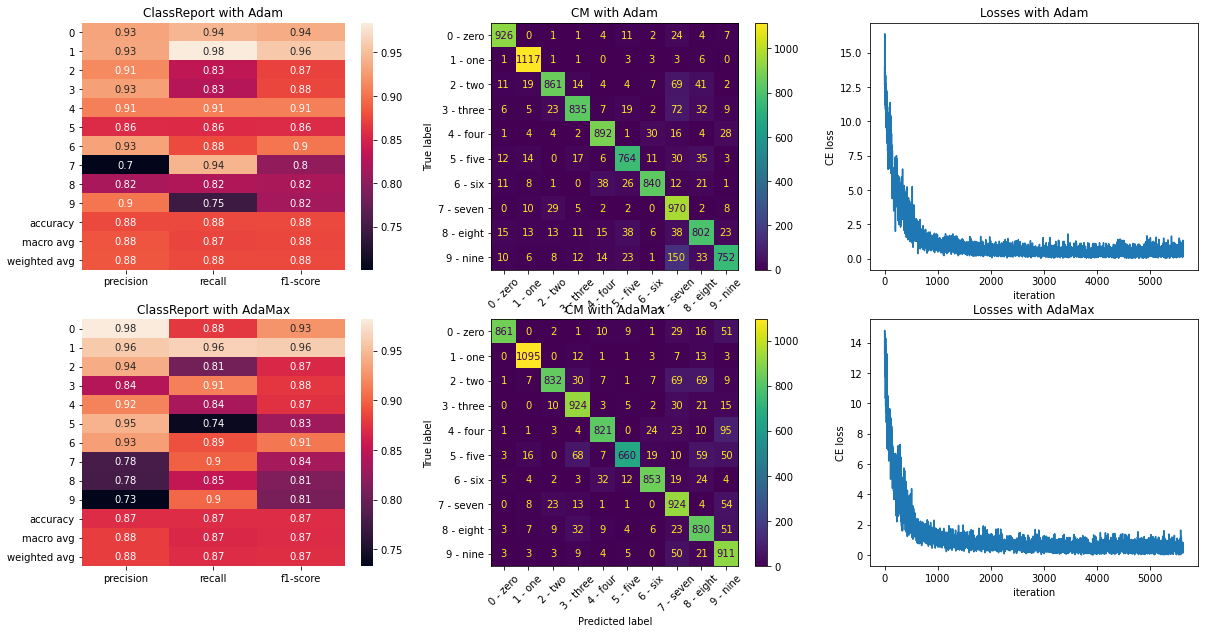

In [36]:
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
i = 0
for name, info in opt_results.items():
    losses, all_labels, all_preds = info.values()
    report = classification_report(all_labels, all_preds, output_dict=True)
    sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, ax=ax[i][0])
    cm = confusion_matrix(all_labels, all_preds)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes).plot(ax=ax[i][1])
    for tick in ax[i][1].get_xticklabels():
        tick.set_rotation(45)
    ax[i][2].plot(losses)
    ax[i][2].set_xlabel('iteration')
    ax[i][2].set_ylabel('CE loss')

    ax[i][0].title.set_text(f'ClassReport with {name}')
    ax[i][1].title.set_text(f'CM with {name}')
    ax[i][2].title.set_text(f'Losses with {name}')

    i += 1
plt.show()